In [1]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import scipy.stats as scis

## Figure recreation

### Classes and functions

In [2]:
#Network nodes
class MetNode:
    def __init__(self, name, essential):
        self.name = name
        self.essential = essential
        self.between_centrality = 0
        self.bridging_coefficient = 0
        self.bridging_centrality = 0
        self.in_edges = None
        self.in_out = None
    
    def find_in_edges(self, edges):
        self.in_edges = [x for x in edges if x[1] == self.name]
        
    def find_out_edges(self, edges):
        self.out_edges = [x for x in edges if x[0] == self.name]

In [3]:
#Builds edges from adjacency matrix, disgustingly O(n^2), sorry
def build_network(adjacency_matrix):
    edges = []
    for row in adjacency_matrix.index:
        for col in adjacency_matrix.columns:
            if adjacency_matrix.at[row, col]:
                new_edge = (row.strip(), col.strip())
                edges.append(new_edge)
    return edges

#### Centrality metrics

In [4]:
"""
The betweenness centrality of a node is the fraction of shortest 
paths from all nodes to all others that pass through the 
particular node.

B(i) = sum(j != k != i) sigma_jk(i)/sigma_jk

where sigma_jk is the total number of shortest paths from node j to node k
sigma_jk(i) total number of those paths that pass through node i

Implementation taken from Brandes, Ulrik (2001). "A faster 
algorithm for betweenness centrality" (PDF). Journal of
Mathematical Sociology. 25 (2): 163–177
"""  

def betweenness_centrality(all_nodes):
    bcs = {} #empty dictionary, will hold betcens
    for s in all_nodes.values():
        bcs[s] = 0 #initalize all to 0
    for j in all_nodes.values():
        S = [] #empty stack
        P = {}
        sigma = {}
        d = {}
        delta = {}
        for k in all_nodes.values():
            P[k] = [] #empty list
            sigma[k] = 0
            d[k] = -1
            delta[k] = 0 #delta[v] <- 0 for v in V
        sigma[j] = 1
        d[j] = 0
        Q = [] # empty queue
        Q.append(j) #enqueue s -> Q
        while Q:
            v = Q[0] # dequeue v <- Q
            Q.remove(v)
            S.append(v) #push v -> S
            for w in [all_nodes[x[1]] for x in v.out_edges]:
                if d[w] < 0:
                    Q.append(w) #enqueue w -> Q
                    d[w] = d[v] + 1 #update distance
                if d[w] == d[v] + 1:
                    sigma[w] += sigma[v]
                    P[w].append(v) #append v -> P[w]
        while S:
            w = S[-1] # pop w <- S
            S.remove(w)
            for v in P[w]:
                delta[v] += (sigma[v]/sigma[w])*(1+delta[w])
                if w != j:
                    bcs[w] += delta[w]
    return bcs

In [5]:
#degree_total(i)^-1/ sum of total degrees of neighbors^-1

def bridging_coefficient(node, all_nodes):
    if len(node.in_edges) == 0 and len(node.out_edges) == 0:
        return 0
    num = total_degree(node)**-1
    denom = 0
    for neighbor in set([all_nodes[edge[1]] for edge in node.out_edges] \
        + [all_nodes[edge[0]] for edge in node.in_edges]):
        denom += total_degree(neighbor)**-1
    return num/float(denom)
        
def total_degree(node):
    return len(node.in_edges) + len(node.out_edges)

In [6]:
#read in essential functions, calculated in MatLab using FBA in COBRA toolbox
def read_essential(filename):
    essential_nodes = []
    with open(filename, 'r') as f:
        essential_nodes = f.read().splitlines()
    return essential_nodes

### Read in data and build network

#### Test on toy graph (Fig 1)

In [7]:
testEdges = [('1', '2'), ('1', '3'), ('1', '4'), ('2', '4'),
             ('3', '4'), ('4', '5'),('5', '6'),('6', '7'),('7', '6')]

testNodes = {}
for i in range(1,8):
    newNode = MetNode(str(i), False) #essential doesn't matter here
    newNode.find_in_edges(testEdges)
    newNode.find_out_edges(testEdges)
    testNodes[str(i)] = newNode

In [8]:
#calculate and update centrality metrics
test_bcs = betweenness_centrality(testNodes) 
for node, val in test_bcs.items():
    node.between_centrality = val
    node.bridging_coefficient = bridging_coefficient(node, testNodes)
    node.bridging_centrality = node.between_centrality * node.bridging_coefficient

In [9]:
#compare against knowns (Table 2)
table_2_vals = [[3, 2, 2, 4, 2, 3, 2],
                [0, 0, 0, 9, 8, 5, 0],
                ['0.2667', '0.8571', '0.8571', '0.1364', '0.8571', '0.3333', '1.5000'],
                [0, 0, 0, 1.2273, 6.8571, 1.6667, 0]]

        #self.between_centrality = 0
        #self.bridging_coefficient = 0
        #self.bridging_centrality = 0
degrees = []
BCs = []
Brs = []
BrCs = []
for key in sorted(testNodes.keys()):
    node = testNodes[key]
    degrees.append(total_degree(node))
    BCs.append(node.between_centrality)
    #rounding + string conversion to get around imperfect float representation
    Brs.append("{0:.4f}".format(round(node.bridging_coefficient/ 0.0001) * 0.0001)) 
    BrCs.append(round(node.bridging_centrality/ 0.0001) * 0.0001)
    
table_2_vals == [degrees, BCs, Brs, BrCs]

True

#### Generate figure with actual data 

In [10]:
#automatically reads 1st sheet, which is E. coli
adjacency_matrix = pd.read_excel('12859_2019_2897_MOESM2_ESM.xlsx', index_col=0)

In [11]:
#construct network from adjacency matrix
am_arcs = build_network(adjacency_matrix)
unique_nodes = set([x[0] for x in am_arcs] + [x[1] for x in am_arcs])

In [12]:
essential_nodes = read_essential('essential_rxns.txt')

In [13]:
#build all reaction nodes, set edges + essential
metNodes = {}
for node in unique_nodes:
    newNode = MetNode(node, node in essential_nodes)
    newNode.find_in_edges(am_arcs)
    newNode.find_out_edges(am_arcs)
    metNodes[node] = newNode #for constant access

In [14]:
#calculate and update centrality metrics
met_bcs = betweenness_centrality(metNodes)
for node, val in met_bcs.items():
    node.between_centrality = val
    node.bridging_coefficient = bridging_coefficient(node, metNodes)
    node.bridging_centrality = node.between_centrality * node.bridging_coefficient

In [15]:
#bin by bridging centrality
bc_bins = {}
    
for node in metNodes.values():
    if node.bridging_centrality == 0:
        cur_bc = 0
    else:
        cur_bc = math.log10(node.bridging_centrality)
    rounded = round(cur_bc*2)/2
    if rounded in bc_bins.keys():
        bc_bins[rounded].append(node)
    else:
        bc_bins[rounded] = [node]

In [16]:
#calculate number + fraction of essential reactions
x = []
y = []
unessential = []
essential = []
for key, val in sorted(bc_bins.items(), key = lambda x: x[0]):
    x.append(key)
    y.append(sum([node.essential for node in val])/len(val))
    essential.append(sum([node.essential for node in val]))
    unessential.append(len(val) - essential[-1])
    print (key, len(val), sum([node.essential for node in val])/len(val))

-0.5 4 0.25
0.0 179 0.05027932960893855
0.5 14 0.07142857142857142
1.0 23 0.08695652173913043
1.5 49 0.1836734693877551
2.0 175 0.16
2.5 362 0.15193370165745856
3.0 312 0.24358974358974358
3.5 116 0.4396551724137931
4.0 16 0.5625
4.5 1 0.0


In [17]:
#linear regression
slope, intercept, r, p, stderr = scis.linregress(x, y)

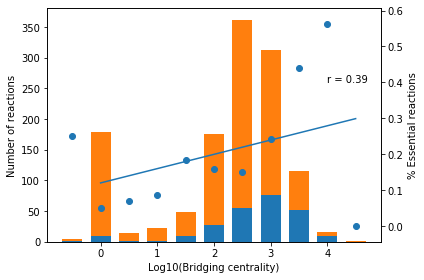

In [18]:
#use all the data to generate the figure
fig, ax1 = plt.subplots()
ax1.set_xlabel("Log10(Bridging centrality)")
ax1.set_ylabel('Number of reactions')
ax1.bar(x, essential, 0.35)
ax1.bar(x, unessential, 0.35, bottom=essential)

ax2 = ax1.twinx()
ax2.set_ylabel("% Essential reactions")
ax2.scatter(x, y)
x_lin = np.linspace(0, 4.5, 18)
y_lin = intercept + slope*x_lin
ax2.plot(x_lin, y_lin)

r_text = "r = {:0.2f}".format(r)
ax2.text(4.0, 0.4, r_text)

fig.tight_layout()
plt.show()